In [1]:
import numpy as np
import matplotlib.pyplot as plt
from napari_flim_phasor_plotter import _synthetic as syn
from scipy.stats import norm
from scipy.signal import convolve

## GT Single Lifetime

In [2]:
def calculate_exp(x, A, tau):
    import numpy as np
    if np.isscalar(tau):
        tau = np.array([tau])
        A = np.array([A])
    return np.sum(A[:, None] * np.exp(-1/tau[:, None]*x), axis = 0)

In [3]:
laser_frequency = 40 # MHz
number_of_time_points = 300
small_time_array = syn.create_time_array(laser_frequency,number_of_time_points)

tau_1 = 0.7
tau_2 = 2
a1 = 1
two_amplitudes = np.array([a1, 1-a1])
tau_array = np.array([tau_1,tau_2])

In [4]:
normalized_counts = calculate_exp(small_time_array, two_amplitudes, tau_array)

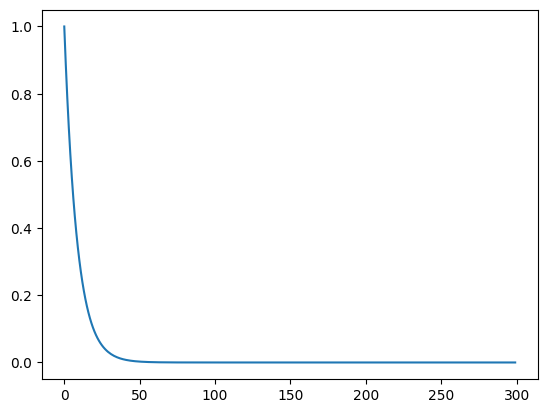

In [5]:
plt.plot(normalized_counts)

## GT IRF

In [96]:
sigma = 0.2 #ns
offset = 3*sigma

syn_irf = norm.pdf(small_time_array, loc = offset, scale = sigma)

syn_irf = syn_irf/np.max(syn_irf)

syn_irf = syn_irf[:16]

In [79]:
syn_irf = norm.pdf(small_time_array, loc = offset, scale = sigma)


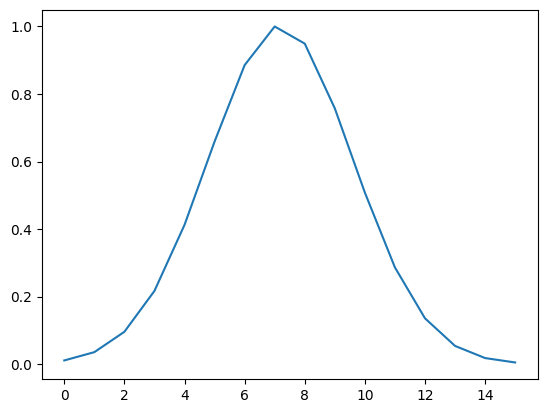

In [8]:
plt.plot(syn_irf)

## Convolution

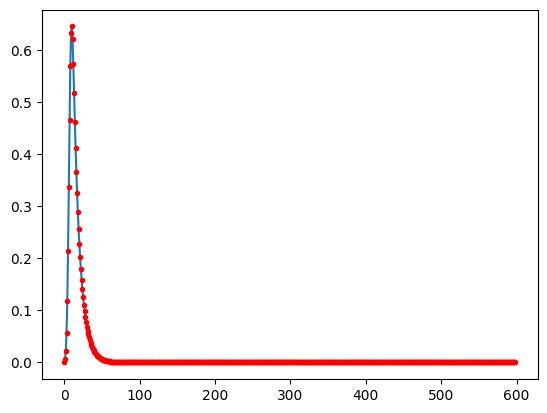

In [48]:
lifetime_signal = convolve(normalized_counts, syn_irf, mode='full')
lifetime_signal = lifetime_signal/syn_irf.sum()
plt.plot(lifetime_signal, '.-', mfc='red', mec = 'red')

In [6]:
def create_synthetic_decay(number_of_output_time_points, amplitudes, life_times, laser_frequency = 40, offset = 0.3, irf_fwhm = 0.1, round_to_int = False):
    import numpy as np
    from scipy.stats import norm
    from scipy.signal import convolve
    from napari_flim_phasor_plotter import _synthetic as syn

    ratio = int(np.rint(10000/number_of_output_time_points))
    number_of_time_points = ratio * number_of_output_time_points
    smooth_time = syn.create_time_array(laser_frequency,number_of_time_points)
    smooth_decay = calculate_exp(smooth_time, amplitudes, life_times)
    smooth_irf = norm.pdf(smooth_time, loc = offset, scale = irf_fwhm)
    smooth_irf = smooth_irf[smooth_irf>0]
    smooth_irf /= np.max(smooth_irf)
    smooth_convolved = convolve(smooth_decay, smooth_irf, mode = "full", method = "direct")
    descaled_convolution = smooth_convolved[::ratio][:number_of_output_time_points]
    descaled_convolution /= np.max(descaled_convolution)
    if round_to_int:
        return(np.rint(descaled_convolution).astype("int"))
    else:
        return(descaled_convolution)

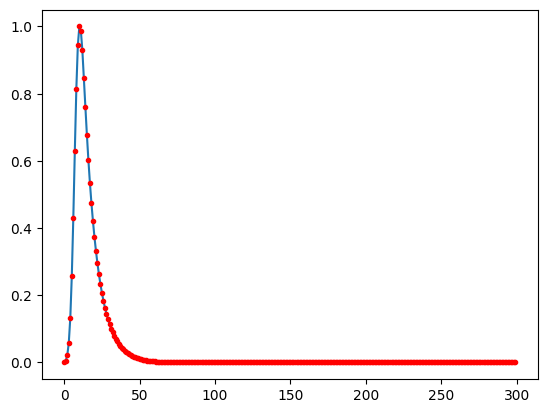

In [11]:
lifetime_counts = create_synthetic_decay(300, two_amplitudes, tau_array, laser_frequency, offset, sigma)
plt.plot(lifetime_counts, '.-', mfc='red', mec = 'red')

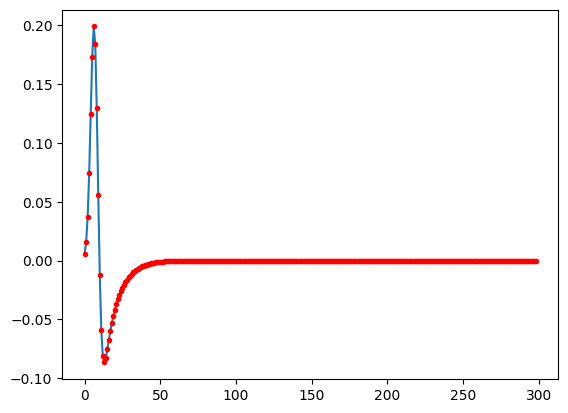

In [12]:
d_lifetime_signal = np.diff(lifetime_counts)
plt.plot(d_lifetime_signal, '.-', mfc='red', mec = 'red')

In [15]:
np.argmax(d_lifetime_signal)

6

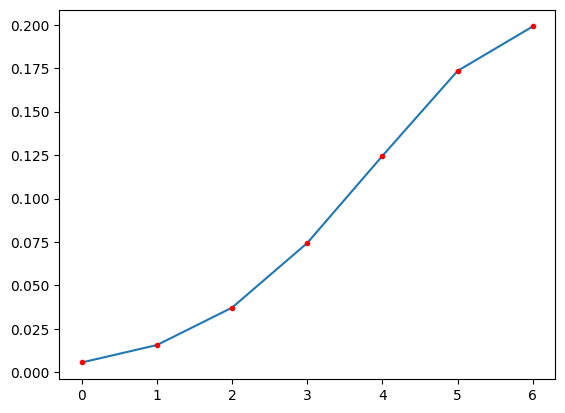

In [29]:
d_lifetime_signal_rise = d_lifetime_signal[:np.argmax(d_lifetime_signal)+1]
plt.plot(d_lifetime_signal_rise, '.-', mfc='red', mec = 'red')

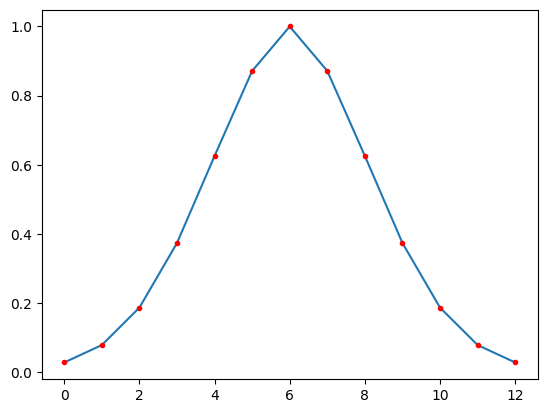

In [32]:
syn_irf_rebuilt = np.concatenate((d_lifetime_signal_rise, d_lifetime_signal_rise[-2::-1]))
syn_irf_rebuilt /= np.amax(syn_irf_rebuilt)
plt.plot(syn_irf_rebuilt, '.-', mfc='red', mec = 'red')

## Deconvolve
Fix code below

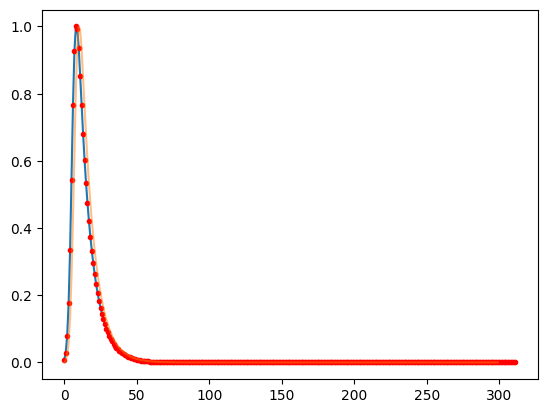

In [37]:
lifetime_signal_rebuilt = convolve(normalized_counts, syn_irf_rebuilt, mode='full')
plt.plot(lifetime_signal_rebuilt/np.max(lifetime_signal_rebuilt), '.-', mfc='red', mec = 'red')
plt.plot(lifetime_counts, alpha = 0.5)

In [38]:
from scipy.signal import deconvolve

In [39]:
lifetime_counts_recovered, remainder = deconvolve(lifetime_counts, syn_irf_rebuilt)

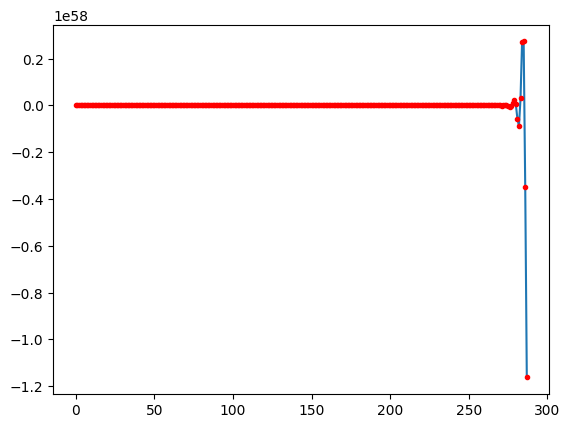

In [49]:
plt.plot(lifetime_counts_recovered*syn_irf_rebuilt.sum(), '.-', mfc='red', mec = 'red')

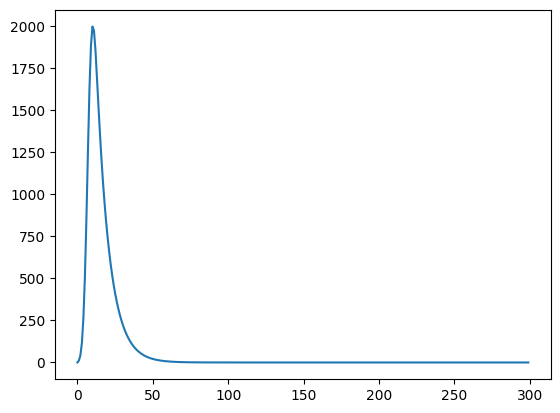

In [56]:
max_photon = 2000
plt.plot(max_photon*lifetime_counts)

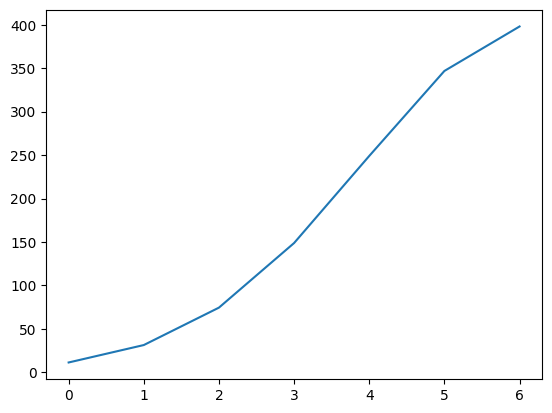

In [57]:
plt.plot(np.diff(max_photon*lifetime_counts)[:np.argmax(np.diff(max_photon*lifetime_counts))+1])

In [58]:
rebuilt_irf =  np.concatenate((np.diff(max_photon*lifetime_counts)[:np.argmax(np.diff(max_photon*lifetime_counts))+1], np.diff(max_photon*lifetime_counts)[:np.argmax(np.diff(max_photon*lifetime_counts))+1][-2::-1]))

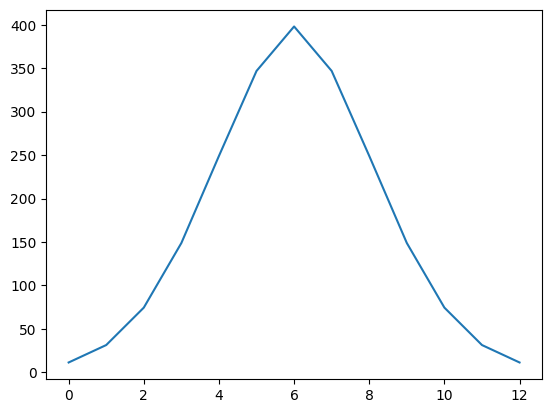

In [59]:
plt.plot(rebuilt_irf)

In [117]:
np.sum(syn_irf>0.0)

16

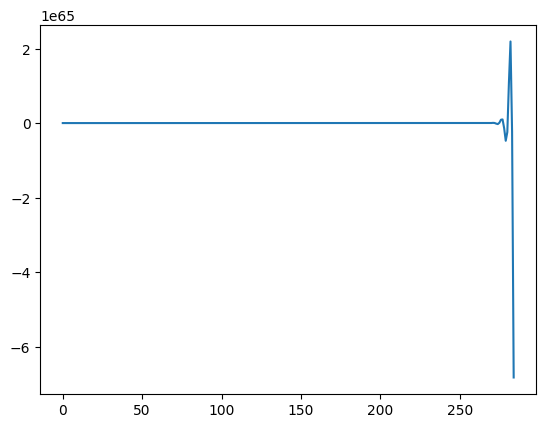

In [179]:
lifetime_counts_recovered,_ = deconvolve(lifetime_counts, syn_irf)
plt.plot(lifetime_counts_recovered)



In [141]:
N = int(2**(np.ceil(np.log2(len(syn_irf) + len(lifetime_counts)))))
N

512

300

In [172]:
from scipy.fft import (fft, ifft, fftshift)


In [173]:
filtered = ifft(fft(lifetime_counts) / fft(syn_irf,len(lifetime_counts)))

(300,)

In [160]:
np.argmax(filtered)

1

/Users/lana/mambaforge/envs/napari-phasor-plotter-dev/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


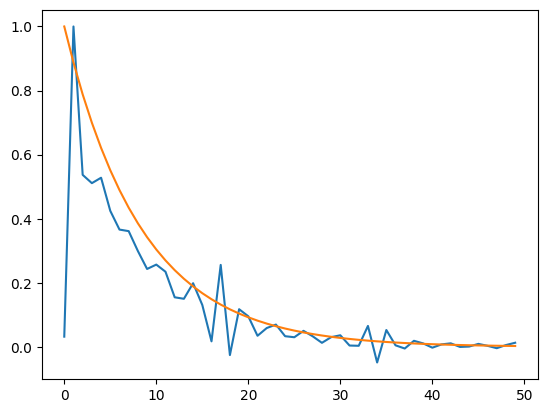

In [174]:
plt.plot((filtered/np.max(filtered))[:50])
plt.plot(normalized_counts[:50])